#  Прогнозирование заказов такси

**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Инструкция по выполнению проекта**

1. Загрузите данные и выполните их ресемплирование по одному часу.
1. Проанализируйте данные.
1. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
1. Проверьте данные на тестовой выборке и сделайте выводы.

**Описание данных**

* Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

Импортируем библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

Импортируем данные.

In [2]:
PATH = '/datasets/taxi.csv'

try:  # local import
    df = pd.read_csv(f'.{PATH}', index_col=[0], parse_dates=[0])
except:  # import from Praktikum server
    df = pd.read_csv(PATH, index_col=[0], parse_dates=[0])

Посмотрим на данные в первом приближении.

In [3]:
print('Порядок индекса монотонен?', df.index.is_monotonic)

display(df.head())
df.info()

Порядок индекса монотонен? True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


* Порядок индекса монотонен
* Интервал между значениями ряда – 10 минут
* Данные о числе заказов с марта по июнь 2018 года

Выполним ресемплирование по одному часу.

In [4]:
df = df.resample('1H').sum()

## Анализ

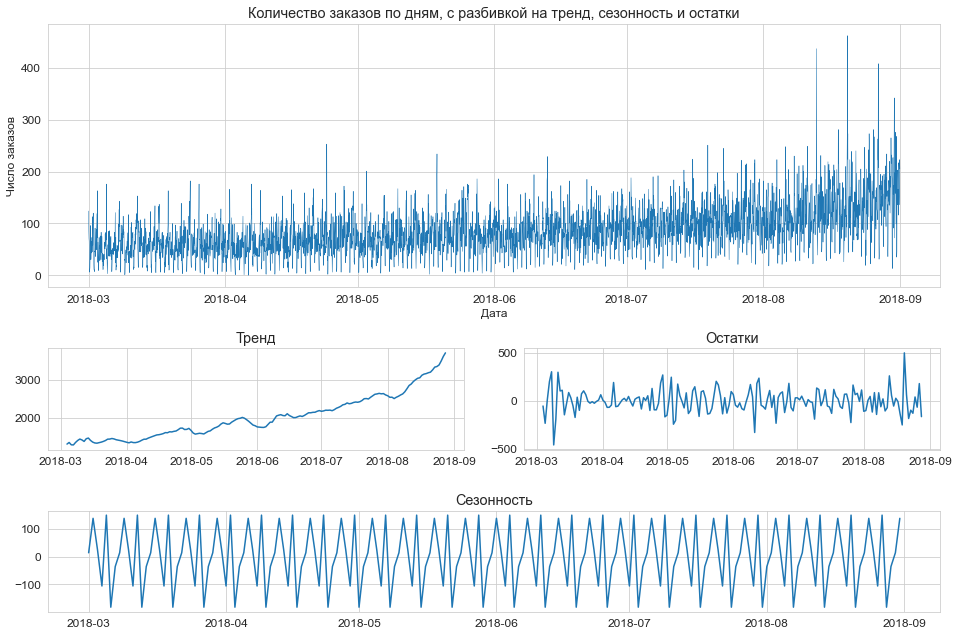

In [5]:
# Style
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 12})

# Data
decomposed = seasonal_decompose(df.resample('1D').sum())

# Grid
gridsize = (4, 4)
fig = plt.figure(figsize=(13.5, 9))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=4, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2)
ax3 = plt.subplot2grid(gridsize, (2, 2), colspan=2)
ax4 = plt.subplot2grid(gridsize, (3, 0), colspan=4)

# Plots
ax1.plot(df, linewidth=0.5)
ax1.set_xlabel('Дата')
ax1.set_ylabel('Число заказов')
ax1.set_title('Количество заказов по дням, с разбивкой на тренд, сезонность и остатки')

ax2.plot(decomposed.trend)
ax2.set_title('Тренд')

ax3.plot(decomposed.resid)
ax3.set_title('Остатки')

ax4.plot(decomposed.seasonal)
ax4.set_title('Сезонность')

plt.tight_layout()
plt.show()

* Мы имеем данные о заказах за 6 месяцев;
* Присутствует восходящий тренд, но неизвестно указывает ли он на внутригодовую сезонность или на глобальный рост;
* Суточная и недельная сезонность, используем это для создания признаков;
* Наблюдается высокая дисперсия в конце периода, вероятно в связи с внешними факторами.

Дополнительно изучим график автокорреляции на сырых данных.

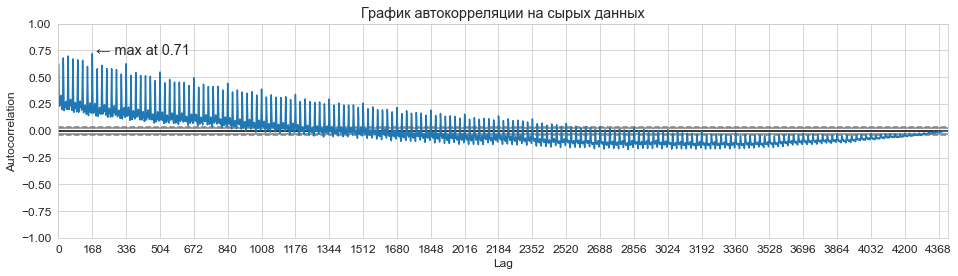

In [6]:
plt.figure(figsize=(13.5, 4))
pd.plotting.autocorrelation_plot(df)

plt.xticks([*range(0, 168*26+1, 168)])
plt.grid(True)
plt.title('График автокорреляции на сырых данных')
plt.text(168, 0.71, ' ← max at 0.71', size='large')

plt.tight_layout()
plt.show()

* Пики каждые 24 часа, затухают по мере увеличения лага.
* Наибольший коэффициент автокорреляции при лаге в 168 часов (7 дней).

Пики на графике автокорелляции подтверждают тезис о наличии дневной и недельной сезонности.

## Обучение

### Feature Engineering

Класс `Vault` используем для хранения результатов.

In [7]:
class Vault:
    def __init__(self):
        self.vault = dict(
            max_lag=[], rolling_mean=[],
            rmse_train=[], 
        )

    def save(self, max_lag, rolling_mean, rmse_train):
        self.vault['max_lag'].append(max_lag)
        self.vault['rolling_mean'].append(rolling_mean)
        self.vault['rmse_train'].append(rmse_train)
    
    def export(self):
        return pd.DataFrame(self.vault)

Функцию `make_features` для создания дополнительных признаков.

In [8]:
def make_features(dataset, source_col, max_lag, rolling_mean_size):

    data, rms = dataset.copy(), rolling_mean_size
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour

    if max_lag > 0:
        for lag in range(1, max_lag + 1):
            data[f'lag_{lag}'] = data[source_col].shift(lag)

    if rolling_mean_size > 0:
        data[f'rolling_mean_{rms}'] = data[source_col].shift(1).rolling(rms).mean()

    return data

Функцию `split` для разделения на тестовую и тренировочную выборки. Используем параметр `offset`, чтобы убрать пропуски.

In [9]:
def split(dataset, target, offset):

    X = dataset.drop(target, axis=1)
    y = dataset[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=False, test_size=0.1)

    return X_train[offset:], X_test, y_train[offset:], y_test

Функция `passage` подготовит данные и посчитает ошибку для заданного набора параметров.

In [10]:
def passage(dataset, target, lag, lag_offset, rms, export=False):

    data = make_features(dataset, source_col=target, max_lag=lag, rolling_mean_size=rms)

    X_train, X_test, y_train, y_test = split(data, target, lag_offset)

    model = LinearRegression().fit(X_train, y_train)
    
    y_pred = model.predict(X_train)

    rmse_train = mse(y_train, y_pred)**0.5
    
    if not export:
        return lag, rms, rmse_train
    else:
        y_pred = pd.Series(y_pred, index=y_train.index)
        return y_train, y_pred

Функция `sanity_check` выведет визулизацию для сравнения качества предсказания с истинными значениями.

In [11]:
def sanity_check(true, prediction):
    # Data
    residuals = prediction - true
    
    # Grid
    gridsize = (3, 1)
    fig = plt.figure(figsize=(13.5, 12))
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (2, 0))

    # Plots
    ax1.plot(true)
    ax1.plot(prediction)
    ax2.plot(residuals)
    pd.plotting.autocorrelation_plot(residuals, ax=ax3)

    # Decoration
    ax1.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='x', labelrotation=45)

    ax1.set_title('Сравнение предсказанных и истинных значений')
    ax1.set_ylabel('Orders')
    ax1.legend(['true', 'prediction'], loc='upper left')

    ax2.set_title('Отклонения предсказаний от истинных значений')
    ax2.set_ylabel('Deviation')
    ax2.legend(['residuals'])

    ax3.set_xticks([*range(0, 168*(len(residuals)//168)+1, 168)])
    ax3.grid(True)
    ax3.set_title('Автокорреляция отклонений')

    plt.tight_layout()
    plt.show()

Зададим фиксированный `offset=168`, чтобы изменяющийся размер обучающей выборки не влиял на оценку `RMSE`.

In [ ]:
# Data
stats = Vault()
for i in range(0, 168+1):
    stats.save(*passage(df, target='num_orders', lag=i, lag_offset=168, rms=168))
lag_test = stats.export()

stats = Vault()
for i in range(0, 168+1):
    stats.save(*passage(df, target='num_orders', lag=168, lag_offset=168, rms=i))
rms_test = stats.export()

# Grid
gridsize = (1, 2)
fig = plt.figure(figsize=(13.5, 3))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))

# Plots
ax1.plot(lag_test['max_lag'], lag_test['rmse_train'])
ax2.plot(rms_test['rolling_mean'], rms_test['rmse_train'])

# Decoration
ax1.set_xticks([*range(0, 168+1, 24)])
ax1.set_title('Зависимость RMSE/Lag при Rolling mean=168')
ax1.set_xlabel('Lag')
ax1.set_ylabel('RMSE Score')

ax2.set_xticks([*range(0, 168+1, 24)])
ax2.set_title('Зависимость RMSE/Rolling mean при Lag=168')
ax2.set_xlabel('Rolling mean')
ax2.set_ylabel('RMSE Score')

plt.tight_layout()
plt.show()

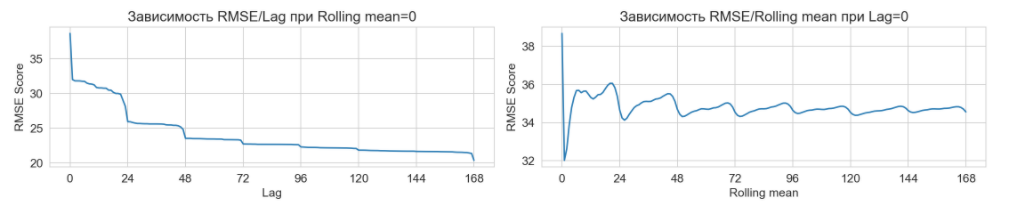

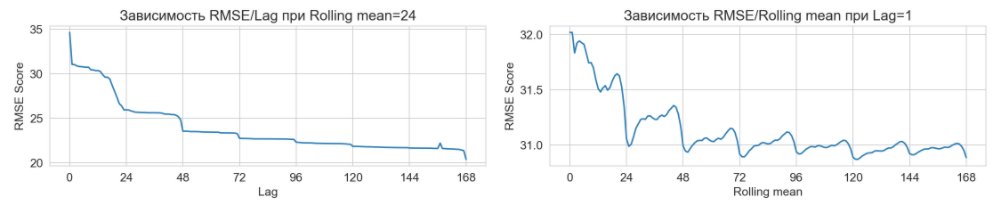

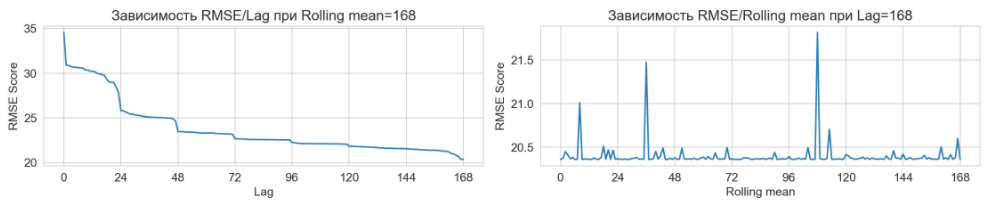

* Оценка RMSE принимает минимальное значение при max_lag=168 – это указывает на то, что сезонности не учтены в факторах, а именно недельная сезонность.

RMSE Score on train: 20.368086


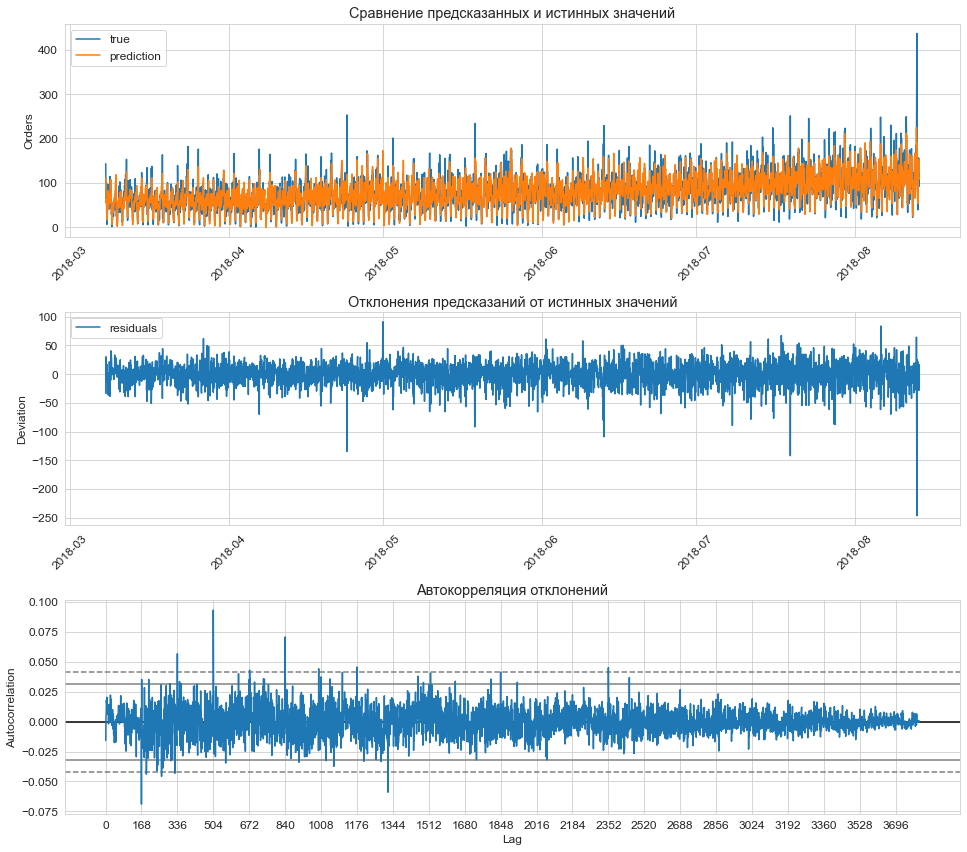

In [12]:
# Data
y_train, y_pred = passage(df, target='num_orders', lag=168, lag_offset=168, rms=24, export=True) 

# RMSE score
print('RMSE Score on train: %f' % mse(y_train, y_pred)**0.5)

# Plots
sanity_check(y_train, y_pred)

### Сравнение моделей

Посмотрим, как с задачей cправятся 4 различных алгоритма.

In [13]:
# Data
target='num_orders'

data = make_features(df, source_col=target, max_lag=168, rolling_mean_size=24)
X_train, X_test, y_train, y_test = split(data, target, offset=168)

LR: -22.543148 (2.607682)
KNN: -25.208513 (3.594489)
RF: -24.136508 (3.640741)
SVR: -32.898948 (6.464528)


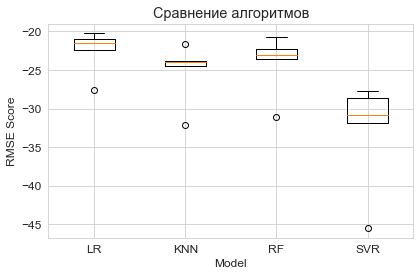

In [14]:
# Models
models = [
    ('LR',  LinearRegression() ),
    ('KNN', KNeighborsRegressor() ),
    ('RF',  RandomForestRegressor(n_estimators=10, random_state=42) ),
    ('SVR', SVR(gamma='auto') ),
]

# Evaluation
results = []
names = []
for name, model in models:
    pipeline = Pipeline(
        [('transformer', StandardScaler()), ('estimator', model)])

    tscv = TimeSeriesSplit(n_splits=5)
    
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

    results.append(cv_results), names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# visualization
plt.boxplot(results, labels=names)
plt.title('Сравнение алгоритмов')
plt.xlabel('Model')
plt.ylabel('RMSE Score')
plt.tight_layout()
plt.show()

* Лучший результат показывает Линейная регрессия, заберём её в финал;

## Тестирование

RMSE Score on train: 20.361379
RMSE Score on test: 34.526446


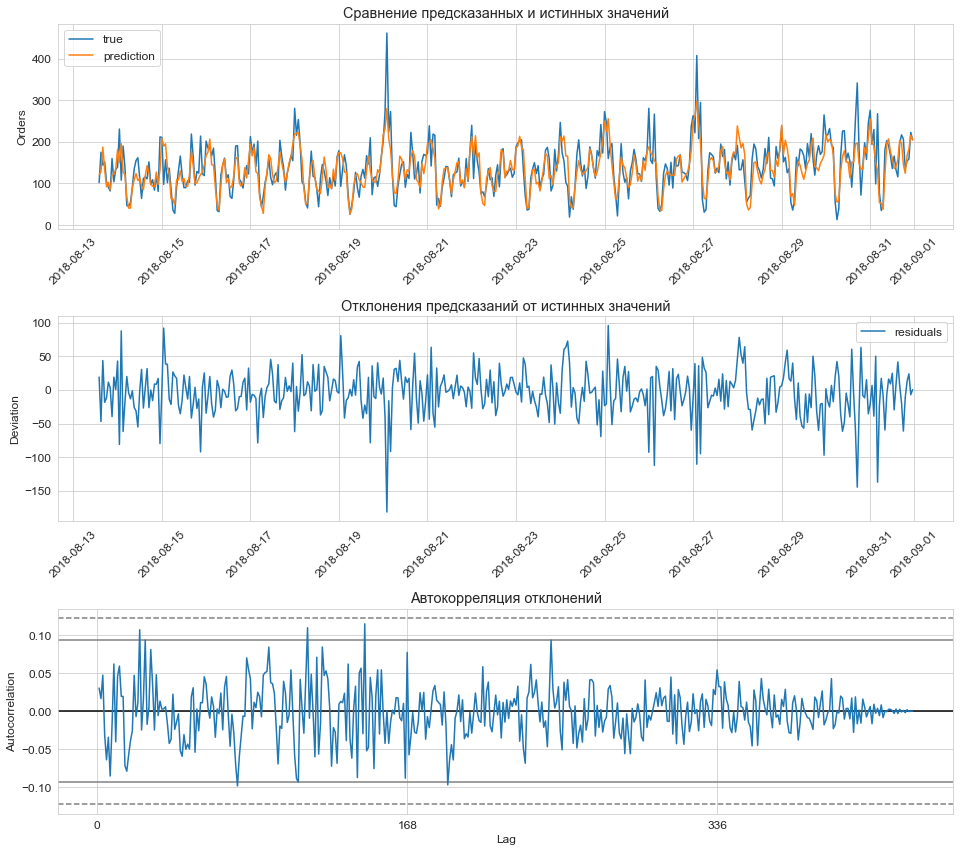

In [15]:
# Data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

estimator = LinearRegression().fit(X_train_sc, y_train)
y_pred = pd.Series(estimator.predict(X_test_sc), index=y_test.index)

# Result print
print('RMSE Score on train: %f' % mse(y_train, estimator.predict(X_train_sc))**0.5)
print('RMSE Score on test: %f' % mse(y_test, y_pred)**0.5)

sanity_check(y_test, y_pred)

Линейная регрессия показала хороший результат на тестовой выборке, `RMSE: 34 (порог 48)`.

Проверим распределение остатков.

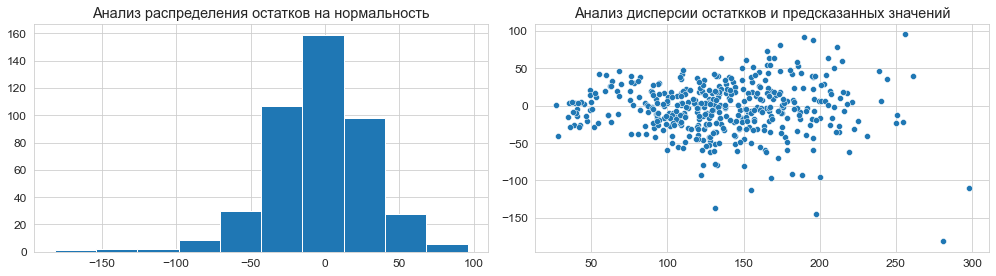

In [16]:
# Data
residuals = y_pred - y_test

# Grid
gridsize = (1, 2)
fig = plt.figure(figsize=(14, 4))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))

# Plots
ax1.hist(residuals)
sns.scatterplot(y_pred, residuals, ax=ax2)

# Decoration
ax1.set_title('Анализ распределения остатков на нормальность')
ax2.set_title('Анализ дисперсии остатков и предсказанных значений')

plt.tight_layout()
plt.show()

* Остатки распределены нормально;
* Дисперсия остатков не зависит от предсказаний.

**Вывод**

Ошибка готовой модели в среднем составляет 35 заказов в час. На графике видно, что в периоды сильных скачков спроса ошибка возрастает, но в остальное время модель достаточно точно угадывает величину спроса. Пороговым значением точности было 48 заказов, таким образом задача проекта выполнена успешно.